In [118]:
from lib import itselfmiti1,util

import numpy as np
import pylab

from qiskit import Aer
from qiskit.opflow import X, Z, I,Y
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.algorithms import VQE, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP,SPSA
from qiskit.circuit.library import TwoLocal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.visualization import plot_bloch_multivector, plot_histogram
from qiskit.providers.ibmq.job import job_monitor
#from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.providers.aer import AerSimulator  , QasmSimulator
from qiskit.quantum_info import state_fidelity
from qiskit.quantum_info import Operator
from qiskit.tools.visualization import circuit_drawer
from qiskit.circuit.library.standard_gates import SGate,SdgGate,ry,rz
import qiskit.quantum_info as qi
from qiskit.exceptions import QiskitError
from qiskit.quantum_info.states.quantum_state import QuantumState
from qiskit import IBMQ
from qiskit.extensions import CXGate, CZGate, U1Gate, U3Gate
from qiskit.circuit import Gate, Instruction, Parameter,ParameterVector



from qiskit.circuit.random import random_circuit
from qiskit.utils.mitigation.fitters import CompleteMeasFitter,TensoredFilter,TensoredMeasFitter
from qiskit.ignis.mitigation.measurement import complete_meas_cal, tensored_meas_cal



import numpy as np
import matplotlib.pyplot as plt
from math import pi as pi

from qiskit.visualization import array_to_latex as lm


import random
import copy



In [119]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q',
                            group='open', 
                            project='main')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_manila'))
backend_real_jakarta = provider.get_backend('ibmq_manila')
backend_sim_ideal = Aer.get_backend('aer_simulator')
BACKEND = backend_sim_noisy_jakarta

ibmqfactory.load_account:WARNING:2022-11-22 15:09:32,403: Credentials are already in use. The existing account in the session will be replaced.


In [120]:
depth=3
N_qubits=5
shots=10000
qubits=[0,1,2,3,4]
qubits_measure=qubits
backend=backend_sim_noisy_jakarta

In [121]:
def Hamiltonian_heisenberg(g,h):
  X1 = X^X^X^I^I
  Y1 = I^I^X^X^X
  Z1 = Z^I^I^I^I
  X2 = I^Z^I^I^I
  Y2 = I^I^Z^I^I
  Y2 = I^I^I^Z^I
  Z2 = I^I^I^I^Z

  H=(h*X1) + \
    (h*X2) + \
    (g*Y1) + \
    (g*Y2) + \
    (g*Z1) + \
    (g*Z2) 
  return H

In [122]:
H=Hamiltonian_heisenberg(1,1)

In [123]:
def ham(num_qubits,depth):
  theta = ParameterVector("t",depth*2)
  qr=QuantumRegister(num_qubits)
  circuit = QuantumCircuit(qr)
  index = 0

  for _ in range (0,depth): 
    for i in range (0,5):
      circuit.h(qr[i])
      circuit.rz(theta[index],qr[i])
    index+=1

    circuit.cx(qr[1],qr[2])
    circuit.cx(qr[3],qr[2])
    circuit.cx(qr[0],qr[1])
    circuit.cx(qr[4],qr[3])

    circuit.rx(theta[index],qr[0])
    #index+=1
    circuit.rx(theta[index],qr[4])
    index+=1

    circuit.cx(qr[4],qr[3])
    circuit.cx(qr[0],qr[1])
    circuit.cx(qr[3],qr[2])
    circuit.cx(qr[1],qr[2])
  
    
  return circuit


In [124]:
TwoLocal_ansatz=TwoLocal(5,'ry','cx','linear',reps=3, insert_barriers=True)

In [125]:
Heisenberg_ansatz=ham(N_qubits,depth)
Heisenberg_ansatz.draw()

┌───┐┌──────────┐          ┌──────────┐            ┌───┐┌──────────┐»
q11511_0: ┤ H ├┤ Rz(t[0]) ├───────■──┤ Rx(t[1]) ├─────■──────┤ H ├┤ Rz(t[2]) ├»
          ├───┤├──────────┤     ┌─┴─┐└──────────┘   ┌─┴─┐    └───┘└──────────┘»
q11511_1: ┤ H ├┤ Rz(t[0]) ├──■──┤ X ├───────────────┤ X ├─────────────────────»
          ├───┤├──────────┤┌─┴─┐├───┤               └───┘            ┌───┐    »
q11511_2: ┤ H ├┤ Rz(t[0]) ├┤ X ├┤ X ├────────────────────────────────┤ X ├────»
          ├───┤├──────────┤└───┘└─┬─┘   ┌───┐                ┌───┐   └─┬─┘    »
q11511_3: ┤ H ├┤ Rz(t[0]) ├───────■─────┤ X ├────────────────┤ X ├─────■──────»
          ├───┤├──────────┤             └─┬─┘    ┌──────────┐└─┬─┘   ┌───┐    »
q11511_4: ┤ H ├┤ Rz(t[0]) ├───────────────■──────┤ Rx(t[1]) ├──■─────┤ H ├────»
          └───┘└──────────┘                      └──────────┘        └───┘    »
«                                                        ┌──────────┐»
«q11511_0: ───────────────────────────────────────────■──┤ Rx(t[3]) ├»
«                         ┌───┐    ┌──────────┐     ┌─┴─┐└──────────┘»
«q11511_1: ─────■─────────┤ H ├────┤ Rz(t[2]) ├──■──┤ X ├────────────»
«             ┌─┴─┐       ├───┤    ├──────────┤┌─┴─┐├───┤            »
«q11511_2: ───┤ X ├───────┤ H ├────┤ Rz(t[2]) ├┤ X ├┤ X ├────────────»
«             ├───┤    ┌──┴───┴───┐└──────────┘└───┘└─┬─┘   ┌───┐    »
«q11511_3: ───┤ H ├────┤ Rz(t[2]) ├───────────────────■─────┤ X ├────»
«          ┌──┴───┴───┐└──────────┘                         └─┬─┘    »
«q11511_4: ┤ Rz(t[2]) ├───────────────────────────────────────■──────»
«          └──────────┘                                              »
«                      ┌───┐┌──────────┐                                    »
«q11511_0: ─────■──────┤ H ├┤ Rz(t[4]) ├────────────────────────────────────»
«             ┌─┴─┐    └───┘└──────────┘               ┌───┐    ┌──────────┐»
«q11511_1: ───┤ X ├──────────────────────────■─────────┤ H ├────┤ Rz(t[4]) ├»
«             └───┘            ┌───┐       ┌─┴─┐       ├───┤    ├──────────┤»
«q11511_2: ────────────────────┤ X ├───────┤ X ├───────┤ H ├────┤ Rz(t[4]) ├»
«                      ┌───┐   └─┬─┘       ├───┤    ┌──┴───┴───┐└──────────┘»
«q11511_3: ────────────┤ X ├─────■─────────┤ H ├────┤ Rz(t[4]) ├────────────»
«          ┌──────────┐└─┬─┘   ┌───┐    ┌──┴───┴───┐└──────────┘            »
«q11511_4: ┤ Rx(t[3]) ├──■─────┤ H ├────┤ Rz(t[4]) ├────────────────────────»
«          └──────────┘        └───┘    └──────────┘                        »
«                    ┌──────────┐                           
«q11511_0: ───────■──┤ Rx(t[5]) ├─────■─────────────────────
«               ┌─┴─┐└──────────┘   ┌─┴─┐                   
«q11511_1: ──■──┤ X ├───────────────┤ X ├────────────────■──
«          ┌─┴─┐├───┤               └───┘         ┌───┐┌─┴─┐
«q11511_2: ┤ X ├┤ X ├─────────────────────────────┤ X ├┤ X ├
«          └───┘└─┬─┘   ┌───┐                ┌───┐└─┬─┘└───┘
«q11511_3: ───────■─────┤ X ├────────────────┤ X ├──■───────
«                       └─┬─┘    ┌──────────┐└─┬─┘          
«q11511_4: ───────────────■──────┤ Rx(t[5]) ├──■────────────
«                                └──────────┘

In [126]:
def ansatz_cal(qc,qubits,backend=BACKEND):
    num_param=qc.num_parameters
    randomlist = []
    config=backend.configuration()
    N_qubits_backend=config.n_qubits
    for i in range(0,num_param):
        n = random.randint(0,100)
        n=2*n*np.pi/100
        randomlist.append(n)
    print(randomlist)
    qr_cal=QuantumRegister(N_qubits)
    qc_cal=QuantumCircuit(qr_cal)
    
    qc_cal.append(qc,qr_cal)
    qc_cal_bound=qc_cal.assign_parameters(randomlist)
    #qc_cal=transpile(qc_cal,BACKEND,optimization_level=0)
    return qc_cal_bound

In [127]:
def Calibration(circ_cal,backend=BACKEND,qubits=qubits,shots_cal=shots):
  
  config=backend.configuration()
  N_qubits_backend=config.n_qubits
  N_qubits=len(qubits)


  meas_calibs, state_labels = util.qiskit_calibration_circuits(N_qubits_backend,qubits_measure=qubits)
  job_cal = execute(meas_calibs, backend=BACKEND, shots=shots)
  cal_results = job_cal.result()
  cal_counts=cal_results.get_counts()
  meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')


  qr = QuantumRegister(N_qubits_backend,name="q")
  qr_qubits=[]
  for qubit in qubits:
    qr_qubits.append(qr[qubit])
  #cr=ClassicalRegister(N_qubits)
  qc = QuantumCircuit(qr)
  qc.append(circ_cal,qr_qubits)
  qc=transpile(qc,backend,optimization_level=0)
  print(qc.count_ops())
  
  cal_circs_GEM, s_labels = util.GEM_calibration_circuits(qc,qubits_measure=qubits)

  job_GEM_L = execute(cal_circs_GEM[0], backend, shots=shots_cal/2, optimization_level=0)
  job_GEM_R = execute(cal_circs_GEM[1], backend, shots=shots_cal/2, optimization_level=0)
  result_L=job_GEM_L.result()
  result_R=job_GEM_R.result()
  print(result_L.get_counts()[0])
  print(result_R.get_counts()[0])
  meas_fitter_GEM_L = CompleteMeasFitter(job_GEM_L.result(), state_labels=state_labels)
  meas_fitter_GEM_R = CompleteMeasFitter(job_GEM_R.result(), state_labels=state_labels)
  C_L = meas_fitter_GEM_L.cal_matrix
  C_R = meas_fitter_GEM_R.cal_matrix
  C_GEM = (C_L+C_R)/2
  print(C_L-C_R)

  rand_vec_prob=np.sum(C_GEM,axis=1,dtype='float')/(len(s_labels))
  C_plus=np.zeros((len(s_labels),len(s_labels)))
  p_t=(C_GEM[0][0]-1)/(rand_vec_prob[0]-1)
  print('p_t')
  print(p_t)

    #define the random prob vector and equilibrium prob vector
  print('rand_vec')
  print(rand_vec_prob)
  rand_vec=p_t*shots*rand_vec_prob
  for k in range (0,len(s_labels)):
    for j in range (0,len(s_labels)):
      C_plus[k][j]=(C_GEM[k][j]-p_t*rand_vec_prob[k])/(1-p_t)

  plt.figure(figsize=(10,16))
  plt.subplot(411)
  plt.imshow(C_GEM)
  plt.colorbar()
  plt.subplot(412)
  plt.imshow(C_plus)
  plt.colorbar()
  print(C_GEM)

  meas_fitter_GP=copy.deepcopy(meas_fitter_GEM_L)
  meas_fitter_GP.cal_matrix=C_plus

  meas_fitter_GEM=copy.deepcopy(meas_fitter_GEM_R)
  meas_fitter_GEM.cal_matrix=C_GEM
  
  return meas_fitter_GEM,meas_fitter_GP,meas_fitter

[3.707079331235956, 4.586725274241098, 6.157521601035994, 5.403539364174444, 0.8168140899333463, 0.06283185307179587]
OrderedDict([('rz', 63), ('sx', 27), ('cx', 24)])
{'00000': 3671, '00110': 135, '01011': 6, '00010': 202, '01010': 16, '00001': 170, '00100': 171, '01110': 82, '10000': 81, '00011': 55, '00111': 43, '01000': 116, '10101': 11, '11000': 53, '10111': 13, '00101': 36, '10110': 16, '01101': 15, '11100': 7, '01100': 23, '10100': 18, '11110': 12, '01111': 13, '01001': 8, '10010': 9, '10011': 4, '10001': 2, '11001': 2, '11111': 2, '11101': 1, '11010': 7}
{'00000': 3897, '00001': 89, '11000': 121, '10000': 93, '10110': 10, '11111': 12, '00100': 102, '01110': 54, '00010': 158, '01000': 72, '11001': 5, '00011': 8, '00110': 140, '11011': 8, '01100': 77, '11010': 12, '10101': 2, '11100': 55, '00101': 12, '10100': 16, '01001': 5, '11110': 10, '00111': 17, '10001': 2, '11101': 8, '10010': 4, '01010': 7, '01101': 2, '10111': 1, '01111': 1}
[[-0.0452  0.0142  0.0042 ... -0.0014 -0.0024 

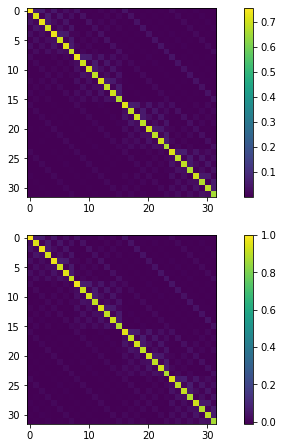

In [128]:
heisenberg_cal=ansatz_cal(Heisenberg_ansatz,qubits=qubits)
meas_GEM_hami,meas_GP_hami,meas_fitter=Calibration(heisenberg_cal,BACKEND,qubits=qubits)

[0.3141592653589793, 0.6283185307179586, 3.7699111843077513, 0.12566370614359174, 5.529203070318036, 1.9477874452256716, 4.523893421169302, 3.707079331235956, 4.523893421169302, 5.780530482605219, 4.649557127312894, 2.6389378290154264, 5.906194188748811, 0.18849555921538758, 3.4557519189487724, 2.324778563656447, 5.843362335677015, 3.6442474781641603, 1.0681415022205298, 5.15221195188726]
OrderedDict([('rz', 60), ('sx', 40), ('cx', 12), ('barrier', 6)])
{'01000': 72, '00000': 4139, '11110': 1, '00100': 152, '00010': 166, '10000': 55, '00001': 154, '00011': 61, '00110': 48, '00111': 16, '01010': 2, '10010': 8, '00101': 49, '11000': 5, '01100': 31, '10100': 7, '11101': 1, '01001': 11, '11001': 1, '10001': 4, '11011': 1, '01110': 9, '01101': 1, '01011': 5, '11100': 1}
{'00000': 4280, '01001': 10, '00001': 263, '10000': 43, '00010': 118, '01110': 8, '00100': 40, '00011': 66, '01100': 20, '10101': 6, '01111': 12, '01000': 59, '01101': 16, '10110': 1, '00101': 2, '10001': 8, '11001': 3, '101

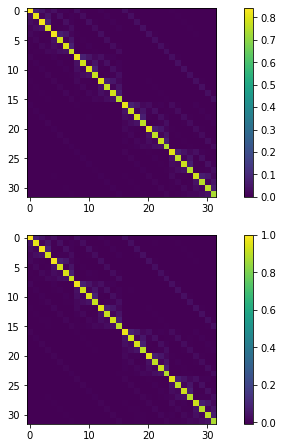

In [129]:
Two_Local_cal=ansatz_cal(TwoLocal_ansatz,qubits=qubits)
meas_GEM_two,meas_GP_two,meas_fitter=Calibration(Two_Local_cal,BACKEND,qubits=qubits)

In [130]:
npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(operator=H)
ref_value = result.eigenvalue.real
print(f'Reference value: {ref_value:.5f}')

Reference value: -4.47214


VQE on Aer qasm simulator (no noise): -4.50195
Delta from reference energy value is: -0.02982


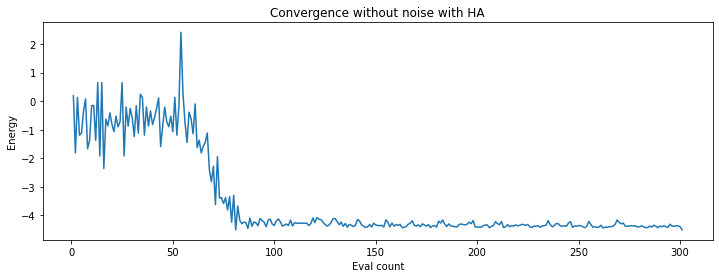

In [131]:
seed = 100
iterations = 125
shots=8192
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,optimization_level=0)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(Heisenberg_ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result.eigenvalue.real-ref_value):.5f}")

# Plot energy values
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts,values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence without noise with HA')
pylab.show()

VQE on Aer qasm simulator (no noise): -4.41406
Delta from reference energy value is: 0.05807


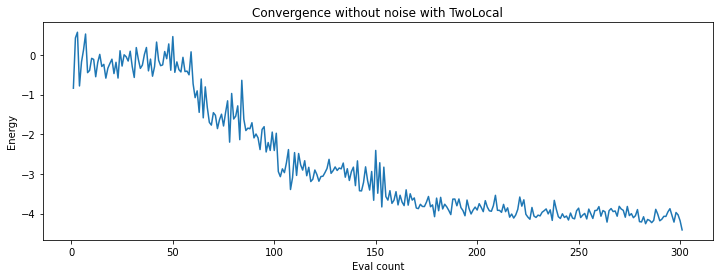

In [132]:
seed = 100
iterations = 125
shots=8192
algorithm_globals.random_seed = seed
backend = Aer.get_backend('aer_simulator')
qi = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed,optimization_level=0)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(TwoLocal_ansatz, optimizer=spsa, callback=store_intermediate_result, quantum_instance=qi)
result = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (no noise): {result.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result.eigenvalue.real-ref_value):.5f}")

# Plot energy values
pylab.rcParams['figure.figsize'] = (12, 4)
pylab.plot(counts,values)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Convergence without noise with TwoLocal')
pylab.show()

VQE on Aer qasm simulator (with noise and measurement error mitigation): -3.74609
Delta from reference energy value is: 0.72604


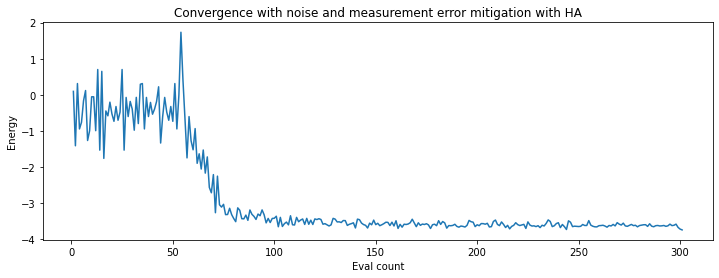

In [133]:
counts2 = []
values2 = []
seed=100
iterations=125
algorithm_globals.random_seed = seed
qi_h_meas = QuantumInstance(backend=BACKEND, seed_simulator=seed, seed_transpiler=seed,optimization_level=0,initial_layout=qubits,measurement_error_mitigation_cls=CompleteMeasFitter)

def store_intermediate_result2(eval_count, parameters, mean, std):
    counts2.append(eval_count)
    values2.append(mean)
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(Heisenberg_ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi_h_meas)
result2 = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result2.eigenvalue.real - ref_value):.5f}")

# Plot energy values
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2,values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise and measurement error mitigation with HA')
    pylab.show()


VQE on Aer qasm simulator (with noise and measurement error mitigation): -4.04883
Delta from reference energy value is: 0.42331


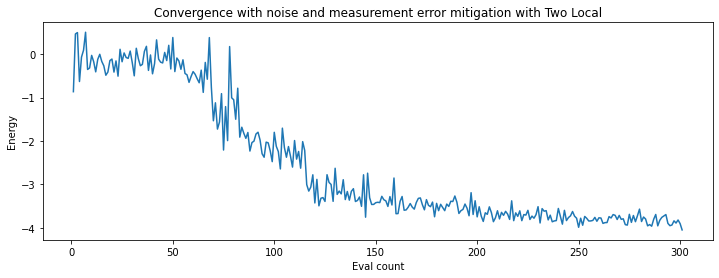

In [134]:
counts2 = []
values2 = []
seed=100
iterations=125
algorithm_globals.random_seed = seed
qi_t_meas= QuantumInstance(backend=BACKEND, seed_simulator=seed, seed_transpiler=seed,
                      measurement_error_mitigation_cls=CompleteMeasFitter,optimization_level=0,initial_layout=qubits)
def store_intermediate_result2(eval_count, parameters, mean, std):
    counts2.append(eval_count)
    values2.append(mean)
#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(TwoLocal_ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi_t_meas)
result2 = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result2.eigenvalue.real - ref_value):.5f}")

# Plot energy values
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2,values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise and measurement error mitigation with Two Local')
    pylab.show()


VQE on Aer qasm simulator (with noise and measurement error mitigation): -4.37109
Delta from reference energy value is: 0.10104


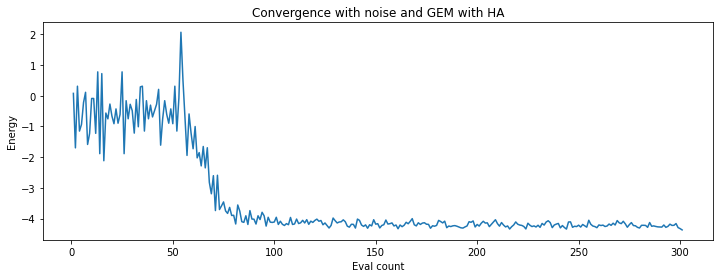

In [135]:
counts2 = []
values2 = []
seed=100
iterations=125
algorithm_globals.random_seed = seed
qi_h_GEM= QuantumInstance(backend=BACKEND, seed_simulator=seed, seed_transpiler=seed,optimization_level=0,initial_layout=qubits,measurement_error_mitigation_cls=CompleteMeasFitter)
qi_h_GEM.measurement_error_mitigation_cls.cal_matrix=meas_GEM_hami.cal_matrix
def store_intermediate_result2(eval_count, parameters, mean, std):
    counts2.append(eval_count)
    values2.append(mean)
ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(Heisenberg_ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi_h_GEM)
result2 = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result2.eigenvalue.real - ref_value):.5f}")

# Plot energy values
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2,values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise and GEM with HA')
    pylab.show()


VQE on Aer qasm simulator (with noise and measurement error mitigation): -4.41406
Delta from reference energy value is: 0.05807
<bound method QuantumInstance.cals_matrix of <qiskit.utils.quantum_instance.QuantumInstance object at 0x2ADE3C10>>


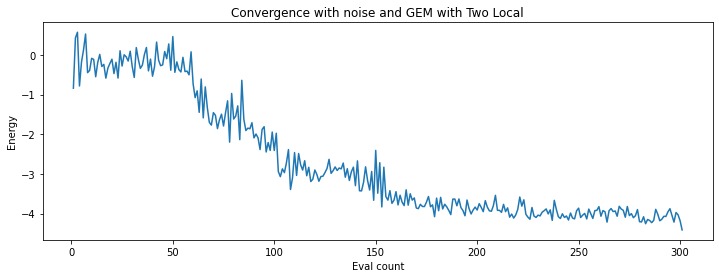

In [136]:
counts2 = []
values2 = []
seed=100
iterations=125
algorithm_globals.random_seed = seed
qi_t_GEM = QuantumInstance(backend=BACKEND, seed_simulator=seed, seed_transpiler=seed,
                      measurement_error_mitigation_cls=CompleteMeasFitter,optimization_level=0,initial_layout=qubits)
qi_t_GEM.measurement_error_mitigation_cls.cal_matrix=meas_GEM_two.cal_matrix
def store_intermediate_result2(eval_count, parameters, mean, std):
    counts2.append(eval_count)
    values2.append(mean)
#ansatz = TwoLocal(rotation_blocks='ry', entanglement_blocks='cz')
spsa = SPSA(maxiter=iterations)
vqe = VQE(TwoLocal_ansatz, optimizer=spsa, callback=store_intermediate_result2, quantum_instance=qi)
result2 = vqe.compute_minimum_eigenvalue(operator=H)
print(f"VQE on Aer qasm simulator (with noise and measurement error mitigation): {result2.eigenvalue.real:.5f}")
print(f"Delta from reference energy value is: {(result2.eigenvalue.real - ref_value):.5f}")
print(qi.cals_matrix)
# Plot energy values
if counts2 or values2:
    pylab.rcParams['figure.figsize'] = (12, 4)
    pylab.plot(counts2,values2)
    pylab.xlabel('Eval count')
    pylab.ylabel('Energy')
    pylab.title('Convergence with noise and GEM with Two Local')
    pylab.show()


In [137]:
print(qi_h_meas.cals_matrix())

{'0_1_2_3_4_1024': (array([[0.7568, 0.0591, 0.0591, ..., 0.0021, 0.003 , 0.0019],
       [0.0259, 0.7133, 0.0087, ..., 0.0073, 0.0022, 0.0026],
       [0.036 , 0.0124, 0.7339, ..., 0.0012, 0.0064, 0.0022],
       ...,
       [0.0009, 0.0055, 0.001 , ..., 0.6692, 0.0081, 0.0504],
       [0.0022, 0.0016, 0.0051, ..., 0.0083, 0.6818, 0.054 ],
       [0.0014, 0.0028, 0.001 , ..., 0.0337, 0.0252, 0.6555]]), 1669126235.7289903)}


In [138]:
print(qi_h_GEM.cals_matrix())

{'0_1_2_3_4_1024': (array([[0.7568, 0.0591, 0.0591, ..., 0.0021, 0.003 , 0.0019],
       [0.0259, 0.7133, 0.0087, ..., 0.0073, 0.0022, 0.0026],
       [0.036 , 0.0124, 0.7339, ..., 0.0012, 0.0064, 0.0022],
       ...,
       [0.0009, 0.0055, 0.001 , ..., 0.6692, 0.0081, 0.0504],
       [0.0022, 0.0016, 0.0051, ..., 0.0083, 0.6818, 0.054 ],
       [0.0014, 0.0028, 0.001 , ..., 0.0337, 0.0252, 0.6555]]), 1669126391.0034897)}
